In [1]:
%load_ext autoreload

In [17]:
%autoreload 2
from copy import deepcopy
from delase import DeLASE
from delase.metrics import mase
from hydra import compose, initialize
from matplotlib import font_manager
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import socket
import sys
from tqdm.auto import tqdm

sys.path.append('..')
from data_utils import filter_data, find_noisy_data, get_delase_results, get_delase_run_list, get_grid_search_results, get_grid_search_run_list, get_grid_search_window_ts, get_section_info, load_session_data, load_window_from_chunks

plt.style.use('../sci_style.mplstyle')
hostname = socket.gethostname()
if 'endeavour' in hostname:
    font_path = "/usr/share/fonts/TTF/Arial.TTF"
else:
    font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

In [3]:
with initialize(version_base="1.3", config_path="../DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [100]:
cfg.params.data_class = 'leverOddball'
# session = "PEDRI_Ketamine_20220222"
# session = "SPOCK_Ketamine_20210707"
session = "SPOCK_Ketamine_20210712"
# session = "SPOCK_Ketamine_20210902"
# session = "SPOCK_Ketamine_20210715"

# cfg.params.data_class = 'propofolPuffTone'
# session = 'Mary-Anesthesia-20160809-01'

In [101]:
session_vars, _, _, _ = load_session_data(session, cfg.params.all_data_dir, ['sessionInfo'], verbose=False)
session_info = session_vars['sessionInfo']

In [102]:
window_df, bad_electrodes, valid_window_starts, plot_kwargs = find_noisy_data(cfg, session, return_all=True)


Loading data: ['sessionInfo', 'lfp', 'trialInfo', 'lfpSchema']...
sessionInfo : dict with keys[Properties,date,dose,drug,expType,infusionEnd,infusionStart,numCorrect,numTrials,pctCorrect,session,subject,tasks,]

lfp : numpy.array(22703472,128,) of type float64

trialInfo : dict with keys[Properties,blockNum,condition,lvr_correct,lvr_outcome,lvr_reactionTime,lvr_responseDir,lvr_responseTime,lvr_rewardTime,lvr_toneOffset,lvr_toneOnset,odd_blockStd,odd_blockType,odd_globalOddball,odd_localOddball,odd_sequence,odd_sequenceEnd,odd_sequenceStart,odd_subblockType,odd_toneOffsets,odd_toneOnsets,odd_trialInBlock,refTime,session,task,trial,trialEnd,trialStart,]

lfpSchema : dict with keys[dataDim,dataUnits,description,dims,history,index,indexUnits,mask,smpInterval,smpRate,timeUnits,userData,]

Data loaded (took 149.31 seconds)


  0%|          | 0/1513 [00:00<?, ?it/s]

In [103]:
start_a = session_info['infusionStart'] + 15*60
start_a = valid_window_starts[np.where(valid_window_starts > start_a)[0][0]]
start_a_late = session_info['infusionStart'] + 150*60
start_a_late = valid_window_starts[np.where(valid_window_starts > start_a_late)[0][0]]
start_w = session_info['infusionStart'] - 15*60
start_w = valid_window_starts[np.where(valid_window_starts > start_w)[0][0]]
directory = pd.read_pickle(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, f"{session}_lfp_chunked_20s", "directory"))
lfp_a = load_window_from_chunks(start_a, start_a + 15, directory)
lfp_a = lfp_a[:, [i for i in range(lfp_a.shape[1]) if i not in bad_electrodes]]
lfp_a_late = load_window_from_chunks(start_a_late, start_a_late + 15, directory)
lfp_a_late = lfp_a_late[:, [i for i in range(lfp_a_late.shape[1]) if i not in bad_electrodes]]
lfp_w = load_window_from_chunks(start_w, start_w + 15, directory)
lfp_w = lfp_w[:, [i for i in range(lfp_w.shape[1]) if i not in bad_electrodes]]


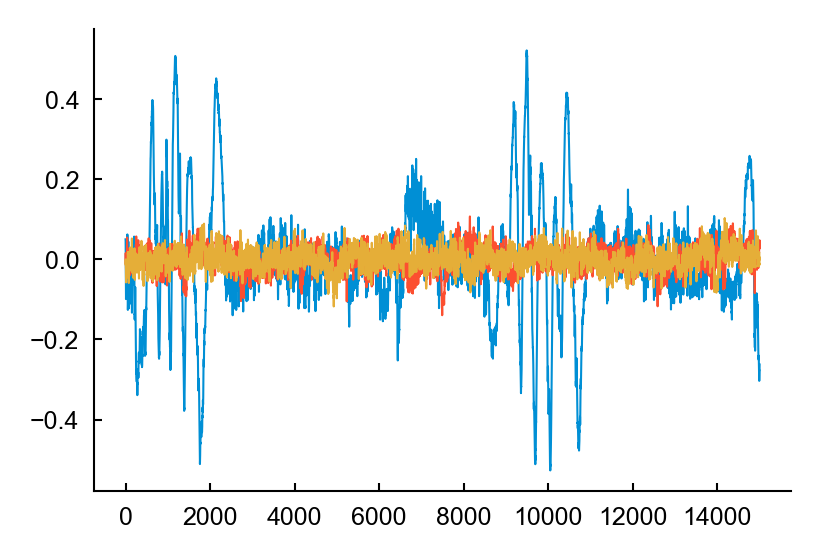

In [104]:
plt.plot(lfp_a[:, 37])
plt.plot(lfp_w[:, 37])
plt.plot(lfp_a_late[:, 37])
plt.show()


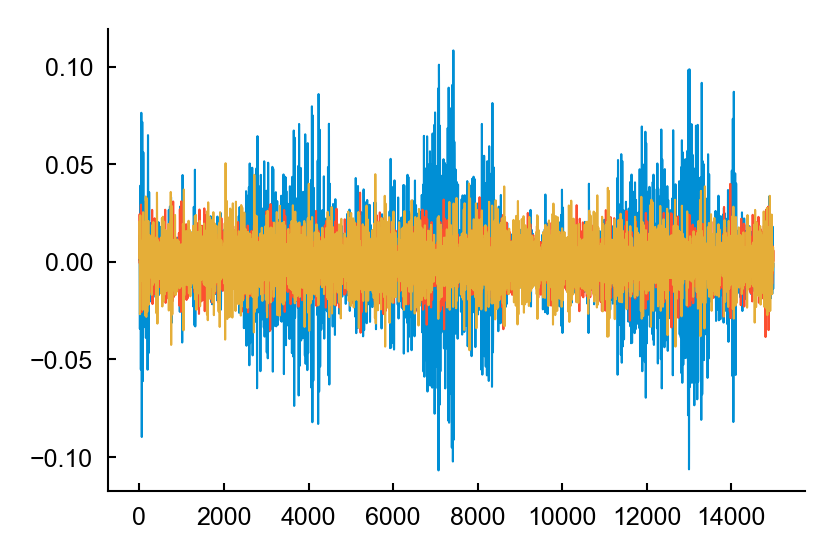

In [105]:
lfp_a_filt = filter_data(lfp_a, cfg.params.low_pass, cfg.params.high_pass, order=2)
lfp_w_filt = filter_data(lfp_w, cfg.params.low_pass, cfg.params.high_pass, order=2)
lfp_a_late_filt = filter_data(lfp_a_late, cfg.params.low_pass, cfg.params.high_pass, order=2)

plt.plot(lfp_a_filt[:, 37])
plt.plot(lfp_w_filt[:, 37])
plt.plot(lfp_a_late_filt[:, 37])
plt.show()


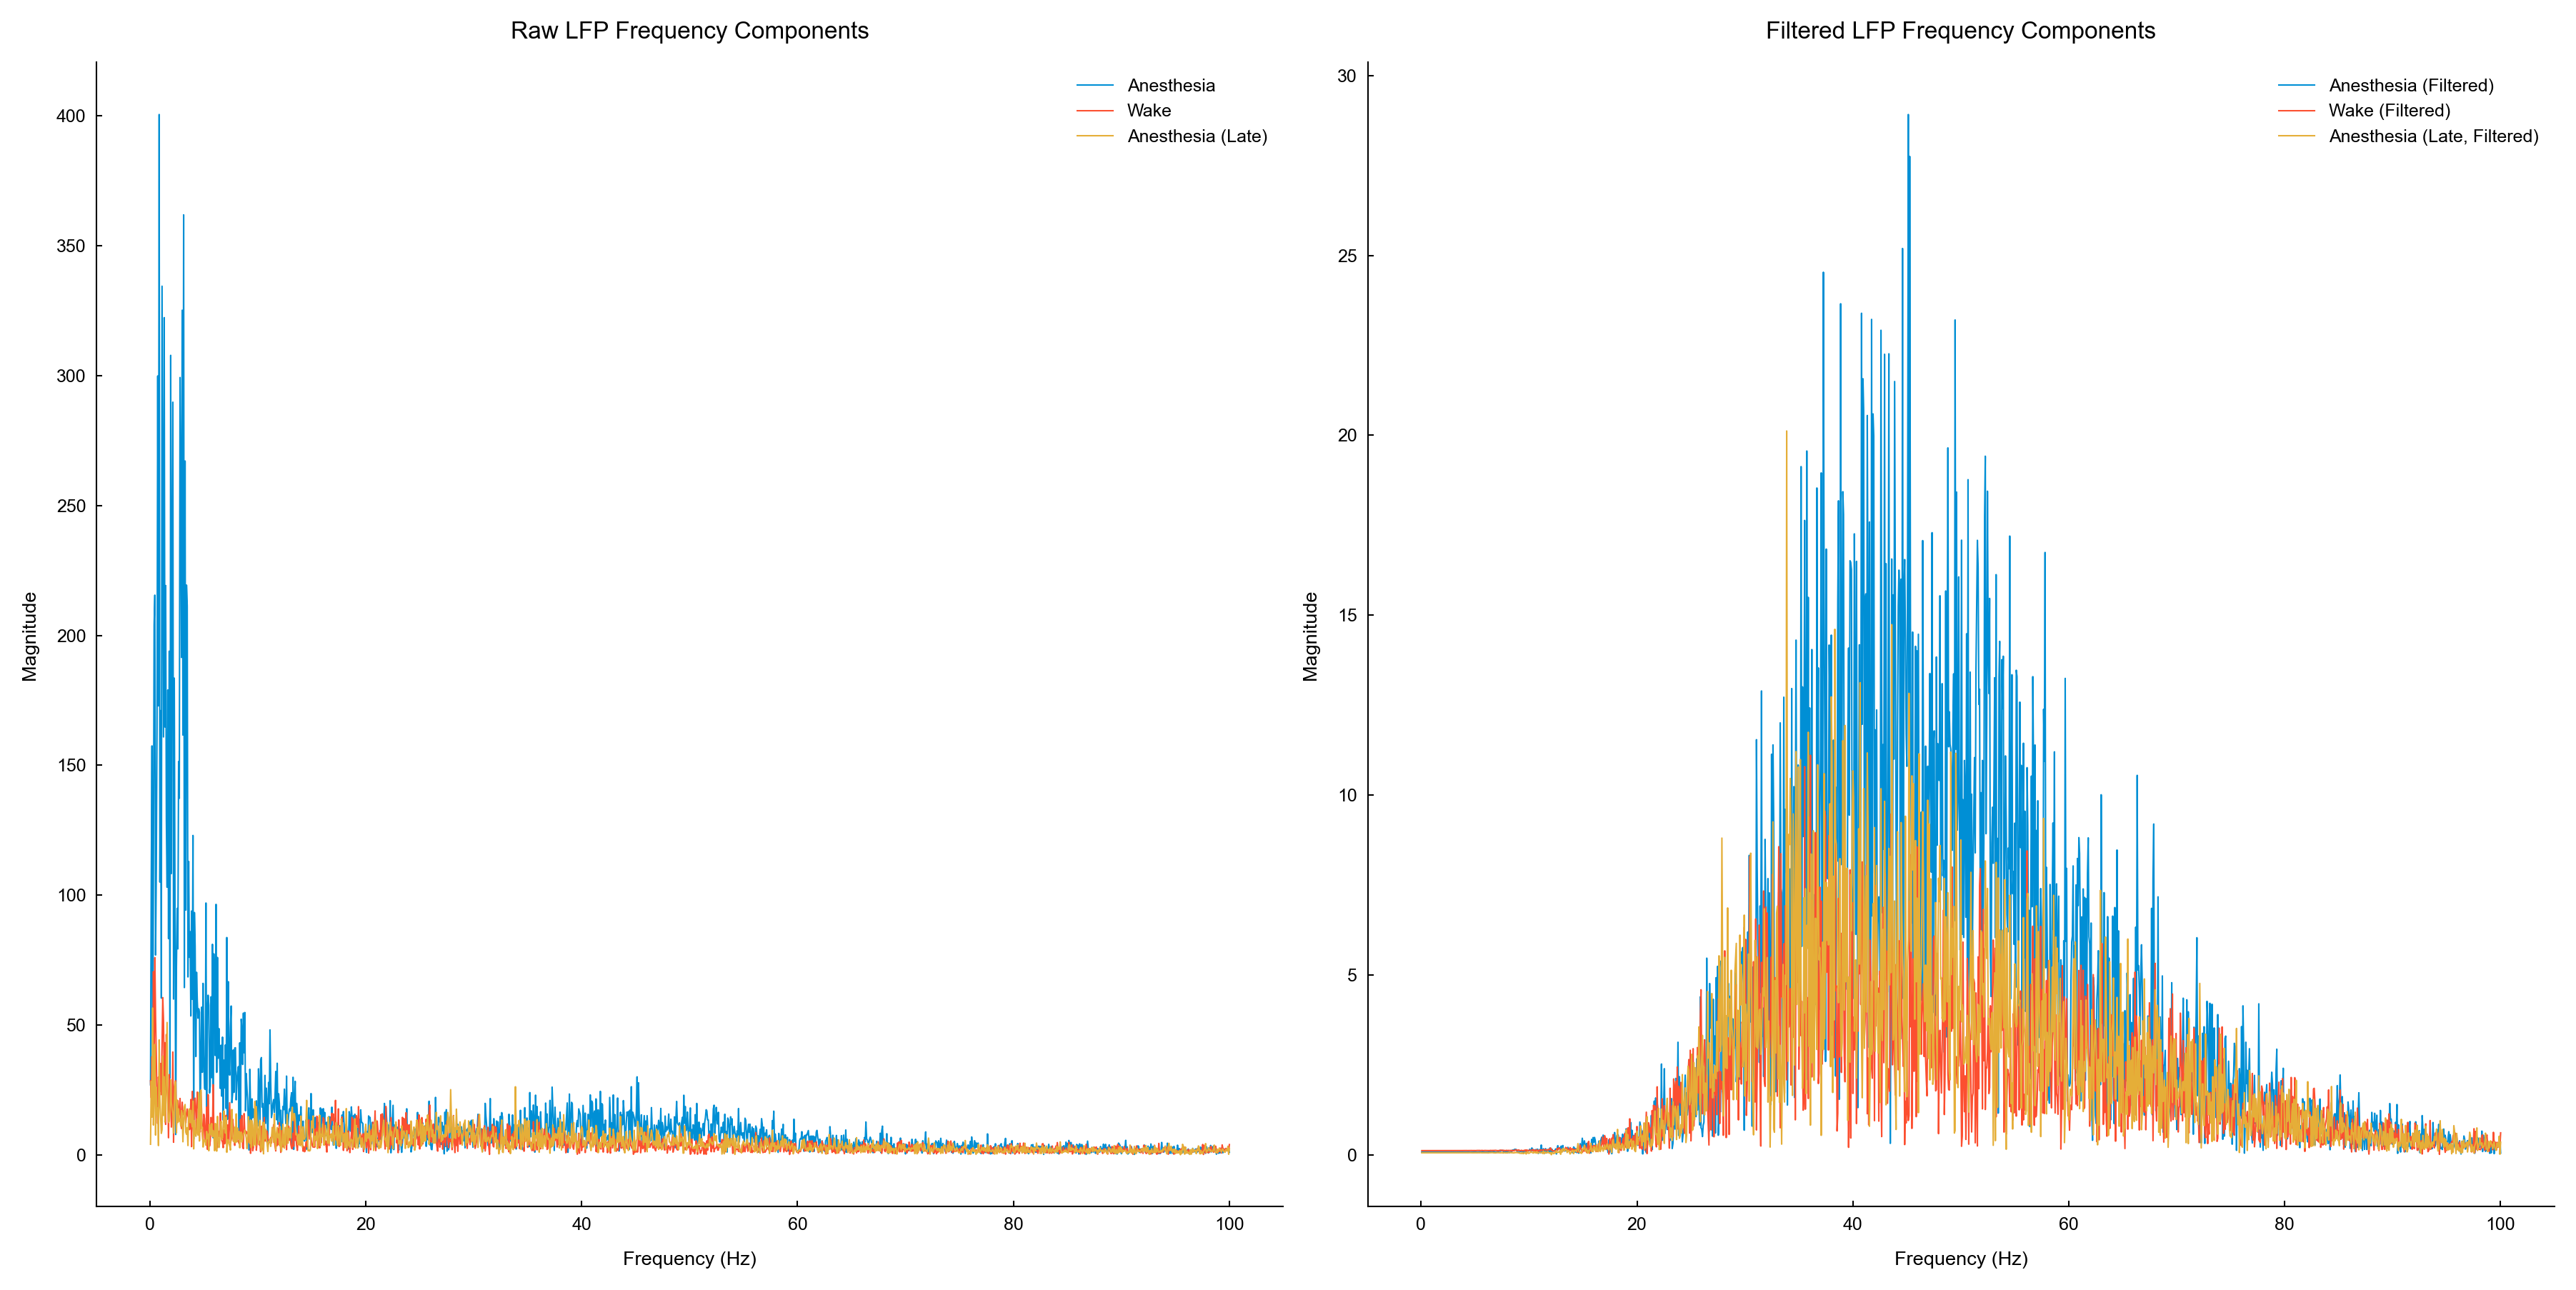

In [112]:
# Calculate FFTs
fs = 1000  # Assuming 1kHz sampling rate based on context
freqs_a = np.fft.fftfreq(len(lfp_a[:, 37]), 1/fs)
freqs_w = np.fft.fftfreq(len(lfp_w[:, 37]), 1/fs)
freqs_a_late = np.fft.fftfreq(len(lfp_a_late[:, 37]), 1/fs)
fft_a = np.abs(np.fft.fft(lfp_a[:, 37]))
fft_w = np.abs(np.fft.fft(lfp_w[:, 37]))
fft_a_late = np.abs(np.fft.fft(lfp_a_late[:, 37]))
fft_a_filt = np.abs(np.fft.fft(lfp_a_filt[:, 37]))
fft_w_filt = np.abs(np.fft.fft(lfp_w_filt[:, 37]))
fft_a_late_filt = np.abs(np.fft.fft(lfp_a_late_filt[:, 37]))

# Plot FFTs
plt.figure(figsize=(12, 6))

plt.subplot(121)
mask = freqs_a[1:len(freqs_a)//2] <= 100
plt.plot(freqs_a[1:len(freqs_a)//2][mask], fft_a[1:len(fft_a)//2][mask], label='Anesthesia')
plt.plot(freqs_w[1:len(freqs_w)//2][mask], fft_w[1:len(fft_w)//2][mask], label='Wake')
plt.plot(freqs_a_late[1:len(freqs_a_late)//2][mask], fft_a_late[1:len(fft_a_late)//2][mask], label='Anesthesia (Late)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Raw LFP Frequency Components')
plt.legend()
# plt.xscale('log')
# plt.yscale('log')

plt.subplot(122)
plt.plot(freqs_a[1:len(freqs_a)//2][mask], fft_a_filt[1:len(fft_a_filt)//2][mask], label='Anesthesia (Filtered)')
plt.plot(freqs_w[1:len(freqs_w)//2][mask], fft_w_filt[1:len(fft_w_filt)//2][mask], label='Wake (Filtered)')
plt.plot(freqs_a_late[1:len(freqs_a_late)//2][mask], fft_a_late_filt[1:len(fft_a_late_filt)//2][mask], label='Anesthesia (Late, Filtered)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Filtered LFP Frequency Components')
plt.legend()
# plt.xscale('log')
# plt.yscale('log')

plt.tight_layout()
plt.show()


In [107]:
delase_w = DeLASE(lfp_w, n_delays=7, rank=850, dt=0.001, max_freq=300, max_unstable_freq=300, device='cuda')
delase_a = DeLASE(lfp_a, n_delays=7, rank=850, dt=0.001, max_freq=300, max_unstable_freq=300, device='cuda')
delase_a_late = DeLASE(lfp_a_late, n_delays=7, rank=850, dt=0.001, max_freq=300, max_unstable_freq=300, device='cuda')

delase_w_filt = DeLASE(lfp_w_filt, n_delays=7, rank=850, dt=0.001, max_freq=300, max_unstable_freq=300, device='cuda')
delase_a_filt = DeLASE(lfp_a_filt, n_delays=7, rank=850, dt=0.001, max_freq=300, max_unstable_freq=300, device='cuda')
delase_a_late_filt = DeLASE(lfp_a_late_filt, n_delays=7, rank=850, dt=0.001, max_freq=300, max_unstable_freq=300, device='cuda')

delase_w_filt.fit()
delase_a_filt.fit()
delase_a_late_filt.fit()
delase_w.fit()
delase_a.fit()
delase_a_late.fit()



In [108]:
print(delase_w.stability_params[:int(0.1*len(delase_w.stability_params))].mean() - delase_a.stability_params[:int(0.1*len(delase_a.stability_params))].mean())
print(delase_w_filt.stability_params[:int(0.1*len(delase_w_filt.stability_params))].mean() - delase_a_filt.stability_params[:int(0.1*len(delase_a_filt.stability_params))].mean())
print(delase_w.stability_params[:int(0.1*len(delase_a_late.stability_params))].mean() - delase_a_late.stability_params[:int(0.1*len(delase_a_late.stability_params))].mean())
print(delase_w_filt.stability_params[:int(0.1*len(delase_a_late_filt.stability_params))].mean() - delase_a_late_filt.stability_params[:int(0.1*len(delase_a_late_filt.stability_params))].mean())


tensor(-11.1148, device='cuda:0')
tensor(-1.6362, device='cuda:0')
tensor(5.4165, device='cuda:0')
tensor(-0.3162, device='cuda:0')


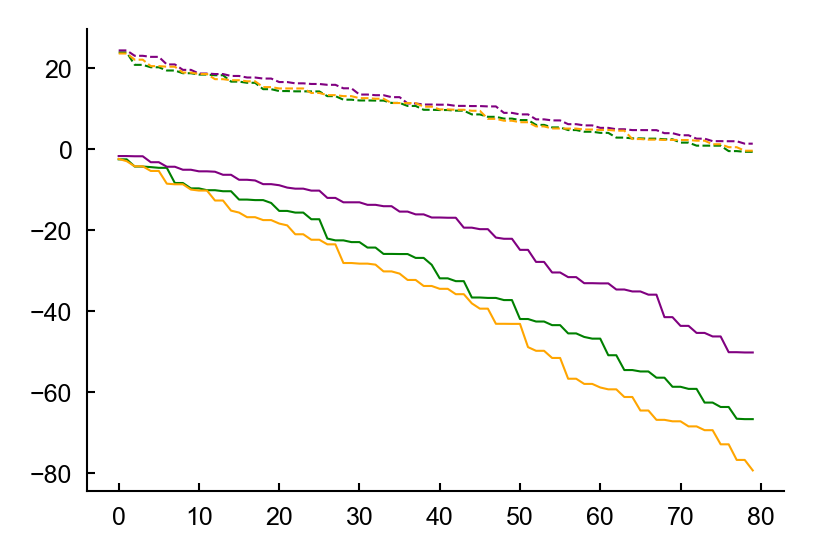

In [109]:
plt.plot(delase_w.stability_params[:int(0.1*len(delase_w.stability_params))].cpu(), c='green')
plt.plot(delase_a.stability_params[:int(0.1*len(delase_a.stability_params))].cpu(), c='purple')
plt.plot(delase_a_late.stability_params[:int(0.1*len(delase_a_late.stability_params))].cpu(), c='orange')
plt.plot(delase_w_filt.stability_params[:int(0.1*len(delase_w_filt.stability_params))].cpu(), c='green', ls='--')
plt.plot(delase_a_filt.stability_params[:int(0.1*len(delase_a_filt.stability_params))].cpu(), c='purple', ls='--')
plt.plot(delase_a_late_filt.stability_params[:int(0.1*len(delase_a_late_filt.stability_params))].cpu(), c='orange', ls='--')
plt.show()


# Find Bad Electrodes

In [5]:
window_df, bad_electrodes, valid_window_starts, plot_kwargs = find_noisy_data(cfg, session, return_all=True)

Loading data: ['sessionInfo', 'lfp', 'trialInfo', 'lfpSchema']...
sessionInfo : dict with keys[Properties,date,dose,drug,expType,infusionEnd,infusionStart,numCorrect,numTrials,pctCorrect,session,subject,tasks,]

lfp : numpy.array(20044884,128,) of type float64

trialInfo : dict with keys[Properties,blockNum,condition,lvr_correct,lvr_outcome,lvr_reactionTime,lvr_responseDir,lvr_responseTime,lvr_rewardTime,lvr_toneOffset,lvr_toneOnset,odd_blockStd,odd_blockType,odd_globalOddball,odd_localOddball,odd_sequence,odd_sequenceEnd,odd_sequenceStart,odd_subblockType,odd_toneOffsets,odd_toneOnsets,odd_trialInBlock,refTime,session,task,trial,trialEnd,trialStart,]

lfpSchema : dict with keys[dataDim,dataUnits,description,dims,history,index,indexUnits,mask,smpInterval,smpRate,timeUnits,userData,]

Data loaded (took 139.47 seconds)


  0%|          | 0/1336 [00:00<?, ?it/s]

In [6]:
def plot_filtering_analysis(window_df, lfp, dt, drug_start, loc, roc, window, wake_amplitude_thresh, anesthesia_amplitude_thresh, electrode_num_thresh, session):
    plt.figure(figsize=(6, 3))

    time_vals = (np.arange(lfp.shape[0])*dt - drug_start)/60

    plt.subplot(2, 3, 1)
    plt.hist(window_df.num_bad_electrodes, bins=20)
    plt.xlabel('# Bad Electrodes')
    plt.ylabel('# Windows')
    plt.title(f"Distribution of Bad Electrode Counts", fontsize=6)

    plt.subplot(2, 3, 2)
    appearances = np.zeros(lfp.shape[-1])
    solo_appearances = np.zeros(lfp.shape[-1])
    for i, row in window_df.iterrows():
        appearances[row.bad_electrodes] += 1
        if row.num_bad_electrodes == 1:
            solo_appearances[row.bad_electrodes] += 1
    plt.scatter(np.arange(len(appearances)), appearances, c='magenta')
    plt.xlabel('Electrode #')
    plt.ylabel('# Appearances')
    plt.title(f"Electrode Appearances in Bad Windows\nNumber of Electrodes with an Appearance: {np.sum(appearances > 0)}", fontsize=6)

    plt.subplot(2, 3, 3)

    plt.scatter(np.arange(len(solo_appearances)), solo_appearances)
    plt.xlabel('Electrode #')
    plt.ylabel('# Appearances')
    plt.title(f"Electrode Solo Appearances in Bad Windows\nNumber of Electrodes with a Solo Appearance: {np.sum(solo_appearances > 0)}", fontsize=6)

    plt.subplot(2, 3, 4)
    # plt.plot(lfp[:, 37])
    ind = np.where(solo_appearances == np.max(solo_appearances[solo_appearances > 0]))[0][0]
    plt.plot(time_vals, lfp[:, ind])
    for i, row in window_df.iterrows():
        if row.noise_window:
            start = int(row.window_start/dt)
            end = int(row.window_end/dt)
            plt.plot(time_vals[start:end], lfp[start:end, ind], color='magenta')
    plt.title(f"Example LFP from Electrode {ind}\nMaximum Number of Solo Appearances ({int(np.max(solo_appearances[solo_appearances > 0]))})", fontsize=6)
    plt.axvline(0, c='plum',label='Drug Start', linestyle='--')
    plt.axvline((loc - drug_start)/60, c='r', label='LOC', linestyle='--')
    plt.axvline((roc - drug_start)/60, c='g', label='ROC', linestyle='--')
    # plt.axvline((ropap - drug_start)/60, c='orange', label='ROPAP', linestyle='--')
    # max_ind = np.abs(lfp[:, ind]).argmax()
    # plt.plot(lfp[max_ind - 30000:max_ind + 30000, ind])

    plt.subplot(2, 3, 5)
    # plt.plot(lfp[:, 37])
    ind = np.where(solo_appearances == np.min(solo_appearances[solo_appearances >= 0]))[0][-1]
    plt.plot(time_vals, lfp[:, ind])
    for i, row in window_df.iterrows():
        if row.noise_window:
            start = int(row.window_start/dt)
            end = int(row.window_end/dt)
            plt.plot(time_vals[start:end], lfp[start:end, ind], color='magenta')
    plt.title(f"Example LFP from Electrode {ind}\nMinimum Number of Solo Appearances ({int(np.min(solo_appearances[solo_appearances > 0]))})", fontsize=6)
    plt.axvline(0, c='plum',label='Drug Start', linestyle='--')
    plt.axvline((loc - drug_start)/60, c='r', label='LOC', linestyle='--')
    plt.axvline((roc - drug_start)/60, c='g', label='ROC', linestyle='--')
    # plt.axvline((ropap - drug_start)/60, c='orange', label='ROPAP', linestyle='--')

    plt.subplot(2, 3, 6)
    for ind in np.where(solo_appearances > 0)[0]:
        max_ind = np.abs(lfp[:, ind]).argmax()
        plt.plot(lfp[max_ind - 5000:max_ind + 5000, ind])
        # plt.plot(lfp[:, ind])
    plt.title(f"Electrodes with Solo Appearances", fontsize=6)

    # max_ind = np.abs(lfp[:, ind]).argmax()
    # plt.plot(lfp[max_ind - 30000:max_ind + 30000, ind])
    plt.suptitle(f"Session: {session}, Window: {window}s\nAmplitude Thresholds: wake={wake_amplitude_thresh}, anesthesia={anesthesia_amplitude_thresh}, Electrode Threshold: {electrode_num_thresh}\nNumber of Noise Windows: {np.sum(window_df.noise_window)} out of {len(window_df)}", fontsize=8)
    plt.tight_layout()
    plt.show()

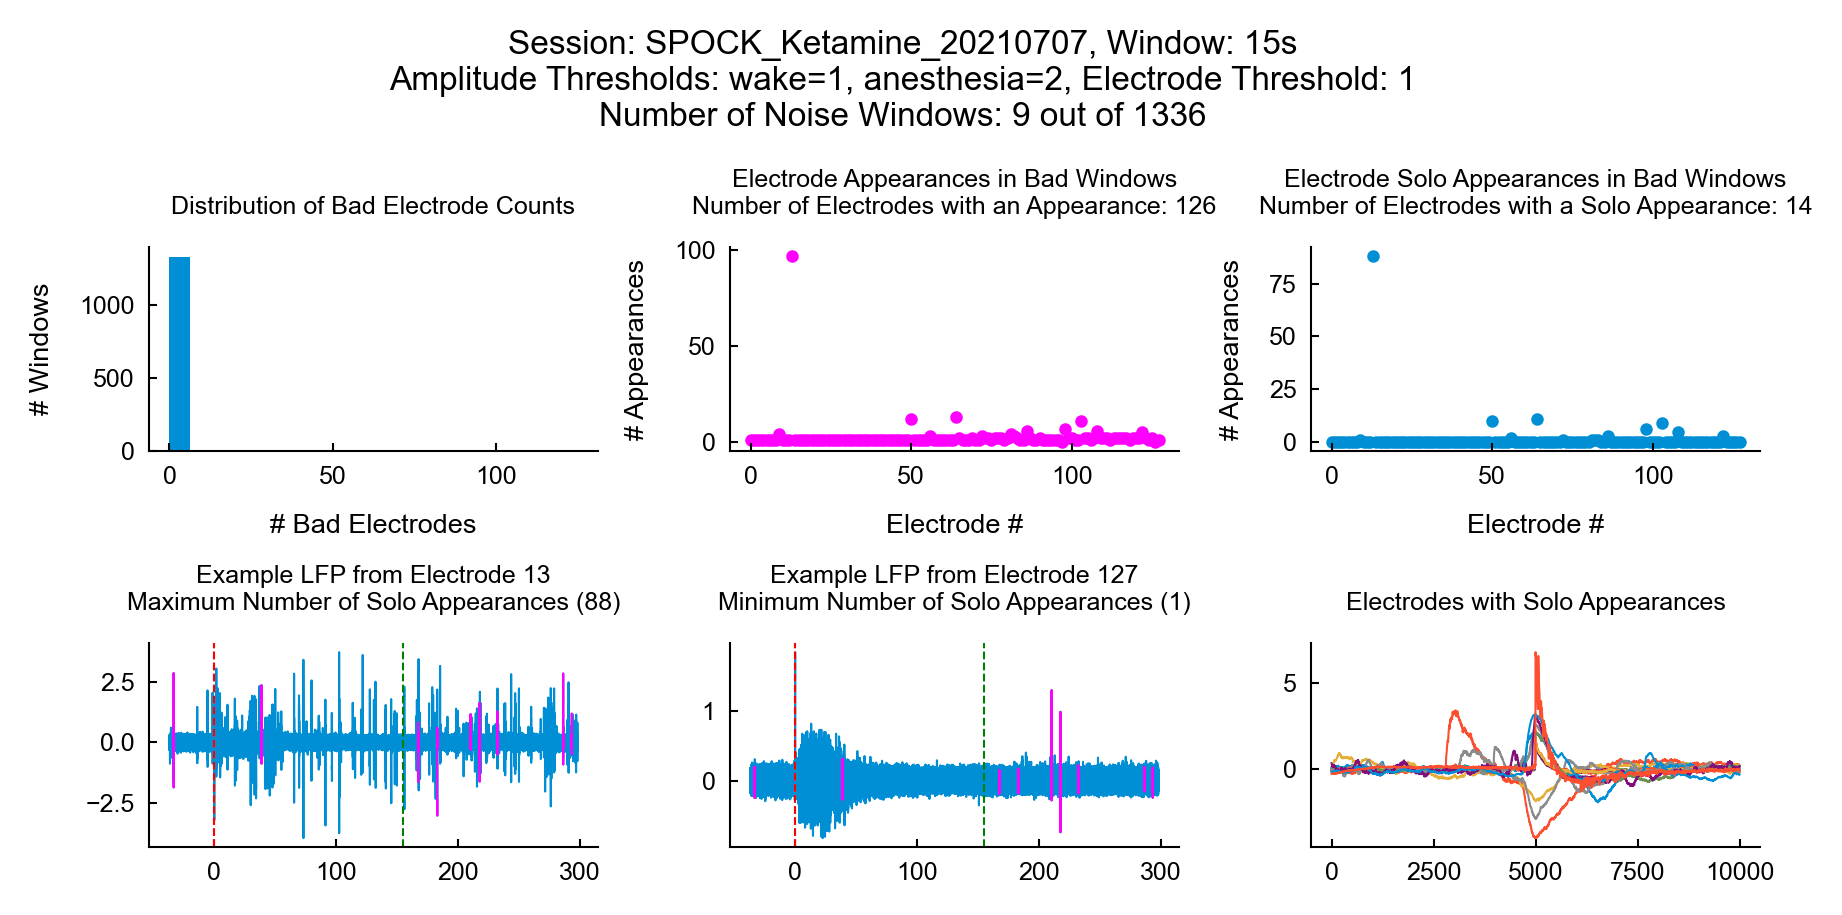

In [7]:
plot_filtering_analysis(window_df, **plot_kwargs)